# Restricted 3-Body Integration of Asteroid Orbits
- Author: Kai Stewart
- Semester: Spring 2020

In [31]:
import time
import random
import numpy as np
from scipy.integrate import RK45 as ODE45
from scipy.integrate import solve_ivp as IVP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline

### Set a random number seed - either for reproducability or variability within the runs

In [32]:
random.seed(time.time())

### Define values of objects and constants
- N is the number of asteroids. An increase in this value causes a linear increase in the runtime
- G is the universal gravitational constant converted to units of: $AU^3 / (kg \cdot Yr^2)$
- M_S is the mass of the Sun in kg
- AU is the value of one astronimical unit in meters -- the mean distance from the center of the sun to the center of the earth.
- M_J is the mass of Jupiter in kg
- R_J is the distance of Jupiter from the Sun in AU
- V_J is the orbital velocity of Jupiter converted to AU/Yr
- M_Ast is a 2-tuple representing the low and high end of asteroid masses in the asteroid belt

[Jupiter Data - Hyperphysics](http://hyperphysics.phy-astr.gsu.edu/hbase/Solar/soldata2.html)

In [33]:
N = 10
G = 6.67e-11 * ( (365*86400)**2 / (1.5e11)**3 )
M_S = 1.99e30
AU = 1.5e11
M_J = 1.898e27
R_J = 5.203
V_J = 13720 * 365 * 86400
M_Ast = (10e10, 10e20)
AUs = (2.1, 3.2)

### Use the center-of-mass definition for the Sun-Jupiter system to compute x-y-coordinates
- Setting the center of the sun as the center of the coordinate system, the center-of-mass follows as the product of each mass with that objects corresponding distance from the center of the coordinate system, divided by the sum of all the object masses.

$\text{CoM}_{Sun-Jupiter} = \frac{ M_S\cdot0 + M_J\cdot R_J}{M_S + R_J}$

In [34]:
# x0_S = -(M_J * R_J)/(M_S + M_J) # [AU]
x0_S = 0 # [AU]
y0_S = 0
vx0_S = 0
vy0_S = 0 # [AU/Yr]

### Define the initial state vector of the sun and jupiter, assuming that both objects are co-planar

In [35]:
s0 = [vx0_S, vy0_S, x0_S, y0_S, 0, V_J, R_J, 0]

### Define the time over which to integrate

In [36]:
t = 100; t_span = (0, t); first_step = 1.0; max_step = np.inf;

# Function definitions

### Function argument for the ODE solver

Note that the graviational force on a mass $M_2$ due to a mass $M_1$ is:

$F_{21} = \frac{GM_1M_2}{|r_{21}|^2}r_{21}$

where $r_{21}$ is the relative position vector for the two bodies and $|r_{21}|$ is:

$|r_{21}| = \sqrt{(x_1 - x_2)^2 + (y_1 + y_2)^2}$.

We are only interested in the action of the Sun and Jupiter on the asteroid, so the computation reduces to object $k$ acting on object $i$. Letting $a = F/m$ yeilds:

$x_i'' = \frac{GM_k(x_k - x_i)}{|r|^3}$

$y_i'' = \frac{GM_k(x_k - x_i)}{|r|^3}$

for $i = 1, 2, 3$ and $k = 1, 2, 3$. 

This system of ODE's we wish to solve for each asteroid, given some intial position and velocity.

In [37]:
def D_grav(t, s_vec, m_arr, G):
    '''
        Function that computes the derivatives of an N-Body Gravity problem. 
        Will be passed to the ODE45 algorithm as an argument.
        Args:
            - t (float): starting time for the numerical integrator. Assumed to begin at one
                         and integrate forwards in time. Unless you're Doc Martin, of course.
            - s_vec (array): system intitial state vector
                - This array needs to have the form: [V_x0, V_y0, X_0, Y_0] repeated for each object.
                  The algorithm assumes that every four entries within the array correspond to a single
                  object, so the entries need to align accordingly.
                - Example: 0: vx0_S, 1: vy0_S, 2: x0_S, 3: y0_S
            - m_arr (array): Masses of the Sun, Jupiter, and a single asteroid. 
                - The array needs to have the form: [M_S, M_J, M_a].
                  The algorithm assumes that the mass information is located at the corresponding
                  indices in the array.
        Returns:
            - dsdt (Numpy array): Array of derivative values for each of the n-asteroids in the simulation.
                                  The array has the form (N*4,): 
                                  [dvx/dt_0, dvy/dt_0, dx/dt_0, dy/dt_0, ... , dvx/dt_N, dvy/dt_N, dx/dt_N, dy/dt_N]
    '''
    verbose = False
    labels = ['sun', 'jupiter', 'asteroid']
    if verbose:
        print(f"t:     {t}")
        print(f"s_vec: {s_vec}")
        print(f"m_arr: {m_arr}")
        print(f"G:     {G}")

    # Set the range of the for-loops to the length of the mass array
    N = len(m_arr)
    assert N==3, "Mass array must be of length 3 only!"
    
    # Set the size of the final storage array to N*4 in order to accomodate
    # vx, vy, x, y data for each of the three objects
    M = N*4
    
    # Arrays to track the position computations
    # - x-velocity - # - y-velocity - # - x-coords - # - y-coords - #
    vx = np.zeros(N); vy = np.zeros(N); x = np.zeros(N); y = np.zeros(N)

    # Arrays to track the derivative computations
    # --- dvx/dt --- # ----- dvy/dt ----- # ----- dx/dt ----- # --- dy/dt --- #
    dvx = np.zeros(N); dvy = np.zeros(N); dx = np.zeros(N); dy = np.zeros(N)
    
    # Again, this loop assumes that every four entries in the state vector
    # correspond to a single object. This algorithm will fail if the state
    # vector is not constructed properly.
    idx = 0; place = 0
    for i in range(0, N):
        if verbose:
            print(f"{labels[idx]}")
            print(f"s_vec[{place}]:",   s_vec[place])
            print(f"s_vec[{place+1}]:", s_vec[place+1])
            print(f"s_vec[{place+2}]:", s_vec[place+2])
            print(f"s_vec[{place+3}]:", s_vec[place+3])
        vx[i] = s_vec[place]
        vy[i] = s_vec[place+1]
        x[i]  = s_vec[place+2]
        y[i]  = s_vec[place+3]
        idx += 1
        place += 4
        
    # Find the total force acting on an asteroid from the Sun and Jupiter.
    for i in range(0, N):
        # Position derivates are given by the current velocity
        dx[i] = vx[i]
        dy[i] = vy[i]
        if verbose:
            print(f"{labels[i]}")
            print(f"\nt: {t}")
            print(f"dx[i]: {dx[i]}")
            print(f"dy[i]: {dy[i]}\n")
        ## Set initial acceleration to zero and sum over the force contributions
        ## from all of the masses (Sun, Jupiter, Asteroid)
        a_x = 0; a_y = 0
        for k in range(0, N):
            if i != k:
                # Find the separation distance
                r_sep = (x[i] - x[k])**2 + (y[i] - y[k])**2
                if verbose:
                    print(f"Accel. computation for {labels[i]},{labels[k]}")
                    print(f"G: {G}")
                    print(f"r_sep              : {r_sep}")
                    print(f"r_sep**(3/2)       : {r_sep**(3/2)}")
                    print(f"m_arr[{labels[k]}] : {m_arr[k]}")
                    print(f"x[{labels[k]}]:      {x[k]}")
                    print(f"x[{labels[i]}]:      {x[i]}")
                    print(f"y[{labels[k]}]:      {y[k]}")
                    print(f"y[{labels[i]}]:      {y[i]}")
                
                # Compute the x-y components of the acceleration of the ith mass due to the kth mass
                a_x = a_x + ((G * m_arr[k] * (x[k] - x[i])) / r_sep**(3/2))
                a_y = a_y + ((G * m_arr[k] * (y[k] - y[i])) / r_sep**(3/2))
                if verbose:
                    print(f"a_x: {a_x}")
                    print(f"a_y: {a_y}")
            else:
                if verbose:
                    print(f"No Accel. computation for {labels[i]},{labels[k]}")
        # Store the computed acceleration values
        dvx[i] = a_x
        dvy[i] = a_y

    # Create a single vector from all of the computed values
    dsdt = np.zeros(M)
    
    idx = 0; place = 0
    for i in range(0, N):
        if verbose:
            print(f"{labels[idx]}")
            print(f"dvx[{place}]:  ", dvx[i])
            print(f"dvy[{place+1}]:", dvy[i])
            print(f"dx[{place+2}]: ", dx[i])
            print(f"dy[{place+3}]: ", dy[i])
        dsdt[place]   = dvx[i]
        dsdt[place+1] = dvy[i]
        dsdt[place+2] = dx[i]
        dsdt[place+3] = dy[i]
        idx += 1
        place += 4
    
    return dsdt

### Random floating point number generator

In [38]:
def random_float(low, high):
    '''
        Function that returns a random floating point number in the range [low, high] inclusive.
        Could use Numpy to do this, but it's more interesting to write my own function.
        Args:
            - low (float): lower bound of desired random float.
            - high (float): upper bound of desired random float.
        Returns:
            - random floating point number
    '''
    return random.random()*(high-low) + low

### Asteroid Generating Function

In [39]:
def make_asteroids(N, G, M_S, M_Ast, AUs):
    '''
        - This function generates randomized arrays corresponding to asteroid masses, their position components
          in cartesian coordinates [AU], and velocity components [AU/Yr]
        Args:
            - N (int): number of asteroids to generate
            - G (float): gravitational constant
            - M_S (float): mass of the sun used to generate random asteroid velocities
            - M_Ast (tuple): 2-tuple of floats representing the low and high end of the masses
                             of asteroids in the asteroid belt
            - AUs (tuple): 2-tuple of astronomical unit used to compute starting positions
        Returns:
            - state_vector (dict) containing:
                - a_masses (Numpy Array): array of N masses, each randomly distributed between 10^10 and 10^20 kg
                - a_x (Numpy Array): array of randomly distributed x-coordinates for N asteroids
                - a_y (Numpy Array): array of randomly distributed y-coordinates for N asteroids
                - v_x (Numpy Array): array of randomly distributed x-velocities for N asteroids
                - v_y (Numpy Array): array of randomly distributed y-velocities for N asteroids
    '''
    # Initialize the arrays
    # ----- Masses ----- ## -- x-coords -- ## -- y-coords -- ## -- x-velocity -- ## -- y-velocity -- #
    a_masses = np.zeros(N); a_x = np.zeros(N); a_y = np.zeros(N); v_x = np.zeros(N); v_y = np.zeros(N)
    # ---------------------------------------------------------------------------------------------- #
    
    print(f'Generating {N} Asteroid(s)')
    # Loop over N asteroids and randomly allocate coordinates and velocities
    for i in range(N):
        # Randomly assign an asteroid mass in the given range using a uniform distribution
        a_masses[i] = random_float(low = M_Ast[0], high = M_Ast[1])
        
        # Randomly assign a starting position in AU from the Sun using a uniform distribution
        r = random_float(low = AUs[0], high = AUs[1])
        
        # Generate a random starting angle between 0 and 2pi
        theta = 2*np.pi*random_float(low = 0.0, high = 1.0)
        
        # Determine the velocity of the asteroid using Kepler's Third Law
        # The period square is proportional to the cube of the semi-major axis, but for this
        # simulation we assume a circular orbit for simplicity.
        P = np.sqrt(r**3)
        
        # The velocity is the circumference of the circular orbit divided by the period
        v = (2*np.pi*r) / P
        
        # Use the velocity and a trigonometric relationship to find the starting 
        # coordinates and starting velocity of the asteroid. We take the orbits
        # to be anti-clockwise, so the starting x-velocity is in the negative direction
        a_x[i] = r*np.cos(theta)
        a_y[i] = r*np.sin(theta)
        
        v_x[i] = -v*np.sin(theta)
        v_y[i] = v*np.cos(theta)
    
    return {'a_masses': a_masses, 'ax': a_x, 'ay': a_y, 'vx': v_x, 'vy': v_y}

### Generate a collection of N asteroids

In [40]:
asteroids = make_asteroids(N, G, M_S, M_Ast, AUs)

Generating 10 Asteroid(s)


#### Set the error tolerances for the numerical integrator

In [41]:
options = {'rtol':1e-8, 'atol':1e-12, 'max_step': np.inf}

#### Prepare lists for storing results

In [42]:
r_init = []; r_final = []; x_coords = []; y_coords = []; #x_jup = []; y_jup = []

## Run the numerical integration using Runge-Kutta Method
[SciPy Solve_IVP Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)

[Runge-Kutta Methods](https://en.wikipedia.org/wiki/Runge–Kutta_methods)

In [43]:
int_steps = 1
for j in range(0, int_steps):
    print(f"Integration round: {j}")
    for i in range(0, N):
        # Periodically update progress to terminal
        if N >= 1000 and i % 1000 == 0:
            print(f"Asteroid: {i}")
        elif N <= 500 and i % 100 == 0:
            print(f"Asteroid: {i}")
        # Calculate the asteroid's initial distance from the Sun
        r_init.append(np.sqrt(asteroids['ax'][i]**2 + asteroids['ay'][i]**2 ))
        
        # Generate the initial state of the asteroid-Jupiter-Sun system
        # We are not interested in the graviational interactions of
        # the asteroids themselves, since this contribution is negligible
        # compared with the contributions from Jupiter and the Sun.
        y0 = s0 + [asteroids['vx'][i], asteroids['vy'][i], asteroids['ax'][i], asteroids['ay'][i]]
        
        # Include the arrays of masses corresponding to the three objects
        masses = [M_S, M_J, asteroids['a_masses'][i]]
        
        # Run the numerical integration
        ## The returned solution is a dictionary containing arrays
        ## t: - the time over which the solution is integrated
        ## y: - the solution of the IVP at each timestep
        solution = IVP(D_grav, t_span, y0, method='RK45', args=(masses, G), **options)
            
        # Compute the final position of the asteroid after integration
        r_final.append(np.sqrt(solution['y'][-1][-1]**2 + solution['y'][-1][-2]**2))
        
        # Get the x- and y-coordinates for the asteroids
        x_coords.append(solution['y'][-2])
        y_coords.append(solution['y'][-1])
        
    # Get the x- and y-coordinates for Jupiter
#     x_jup.append(solution['y'][6])
#     y_jup.append(solution['y'][7])

Integration round: 0
Asteroid: 0


### Convert collection of position information to numpy arrays

In [44]:
x_coords = np.asarray(x_coords)
y_coords = np.asarray(y_coords)

In [45]:
# Find the shortest data array
min_x = min([x_coords[k].shape[0] for k in range(N)])

### Write the computed coordinates to text files

#### Asteroid Data

In [46]:
z_coords = np.zeros((min_x))
for i in range(0, N):
    data = np.vstack((x_coords[i][0:min_x], y_coords[i][0:min_x], z_coords))
    np.savetxt(f"./data/asteroids/asteroid{i}.txt", data)

#### Sun Data - Sun is centered for entire animation

In [47]:
# data = np.vstack((np.zeros((min_x)), np.zeros((min_x)), np.zeros((min_x))))
# np.savetxt(f"./data/sun.txt", data)

#### Jupiter Data

In [48]:
n = min_x
x_jup = [np.cos(2*np.pi/n*x)*R_J for x in range(0, n+1)]
y_jup = [np.sin(2*np.pi/n*x)*R_J for x in range(0, n+1)]

In [49]:
data = np.vstack((x_jup[0:min_x], y_jup[0:min_x], z_coords))
np.savetxt(f"./data/jupiter/jupiter{0}.txt", data)

In [50]:
# del x_coords
# del y_coords
# del x_jup
# del y_jup

[Python n-Body Animation Function](https://github.com/Adnan-Ali-Ahmad/Python-animation/blob/master/3D_animation.py)

In [51]:
# flat_orbits = []
# for x_vec, y_vec in zip(x_coords, y_coords):
#     for i , (x, y) in enumerate(zip(x_vec, y_vec)):
#         fig, ax = plt.subplots()
#         ax.scatter(x, y)
#         ax.scatter(0, 0, c = 'k', marker = '*', s = 500)
#         ax.set_xlim(-x_rng, x_rng)    
#         ax.set_ylim(-y_rng, y_rng)
    
#         # Used to return the plot as an image array
#         fig.canvas.draw()       # draw the canvas, cache the renderer
#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#         image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#         flat_orbits.append(image)
#         if i % 50 == 0:
#             plt.show()
#         plt.close()

In [52]:
# imageio.mimsave(f'./flat_orbits.gif', flat_orbits, fps=15.0)

In [53]:
# del flat_orbits
# del fig

## Plot histogram of asteroid distributions

#### Initial Distributions

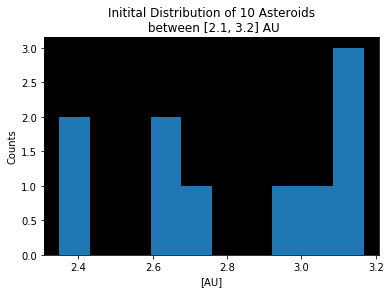

In [54]:
plt.rcParams['axes.facecolor']='#000000'
fig, ax = plt.subplots()
plt.title(f"Initital Distribution of {N} Asteroids\n between [{AUs[0]}, {AUs[1]}] AU")
ax.hist(r_init)
ax.set_xlabel('[AU]')
ax.set_ylabel('Counts')
plt.show()
plt.savefig(f"Initital_Distribution.png", dpi = 300)
plt.close()

#### Final Distributions

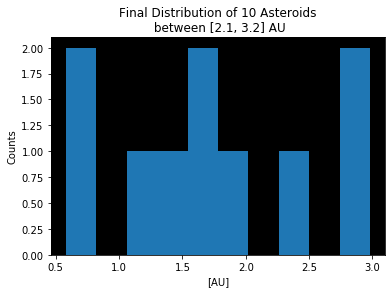

In [55]:
fig, ax = plt.subplots()
plt.title(f"Final Distribution of {N} Asteroids\n between [{AUs[0]}, {AUs[1]}] AU")
ax.hist(r_final)
ax.set_xlabel('[AU]')
ax.set_ylabel('Counts')
plt.show()
plt.close()

# N-Body Animation Function

In [65]:
def update_anim(i, ast_data, dots) :
    time = i
    ax.set_xlabel(f'X [AU]\nSteps:{i} years', color = '#FFFFFF')
    ax.set_ylabel(f'Y [AU]\nSteps:{i} years', color = '#FFFFFF')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0))
    for dot, data in zip(dots, ast_data) :
            dot.set_data((data[0][i], data[1][i]))
            dot.set_3d_properties(data[2][i])
    return dots

In [57]:
ast_data = []

# Read asteroid data
for asteroid in range(0, N):
    data = np.loadtxt(f"./data/asteroids/asteroid{asteroid}.txt")
    ast_data.append([data[0], data[1], data[2]])

# Convert lists to single numpy array
ast_data = np.array(ast_data) # Shape: [N, 3]

In [58]:
# Generate Sun Data
sun_data = np.copy(ast_data)
sun_data.fill(0)

In [59]:
jup_data = []

# Read jupiter data
data = np.loadtxt(f"./data/jupiter/jupiter0.txt")
jup_data.append([data[0], data[1], data[2]])

# Convert lists to single numpy array
jup_data = np.array(jup_data) # Shape: [N, 3]

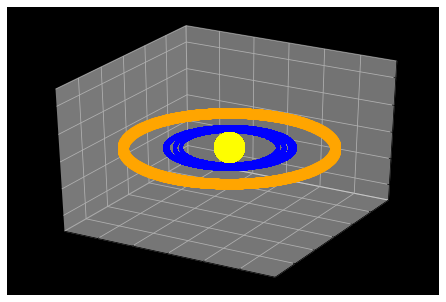

In [60]:
plt.rcParams['axes.facecolor']='#000000'
fig  = plt.figure()
ax   = Axes3D(fig)

# Plot asteroid data
dots = [ax.plot(dat[0], dat[1], dat[2], 'o', markersize=2, color='blue', alpha = 0.75)[0] for i, dat in enumerate(ast_data)]

# Plot Jupiter data
jups = [ax.plot(dat[0], dat[1], dat[2], 'o', markersize=10, color='orange')[0] for i, dat in enumerate(jup_data)]

# Plot Sun data
suns = [ax.plot(dat[0], dat[1], dat[2], 'o', markersize=30, color='yellow', alpha = 0.50)[0] for i, dat in enumerate(sun_data)]

In [61]:
# Put the solar system back together
ast_data = np.concatenate((ast_data, sun_data, jup_data), axis=0)
dots.extend(suns)
dots.extend(jups)

In [62]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

### Write and save the animation

In [66]:
anim = animation.FuncAnimation(fig, update_anim, ast_data[0][0].size, fargs=(ast_data, dots), interval=1, blit=False)

In [ ]:
anim.save(f"restricted_{N}-Body.mp4", writer=writer, savefig_kwargs={'transparent': True, 'facecolor': '#000000'})